<a href="https://colab.research.google.com/github/Darren7218/AI_Predict_Employee_Salary/blob/main/AIT_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AIT Assignment**

Each team member select at least 1 model to do

Dataset: Tech_employee_salary.csv
# Objective: Predict IT professionals’ salary category (Low, Medium, High)
# ========# ================================
# UCCD2063 Artificial Intelligence Techniques
# Group Assignment (June 2025)
# ================================
# Dataset: Tech_employee_salary.csv
# Objective: Predict IT professionals’ salary category (Low, Medium, High)
# ================================

1. Setup

In [ ]:
# Install & import required packages
!pip install catboost lightgbm tensorflow xgboost


# --- Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# CatBoost, LightGBM, XGBoost
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2. Load Dataset

In [ ]:
# Load dataset
df = pd.read_csv("Tech_employee_salary.csv")

# Display basic info
print(df.shape)
df.head()
df.info()
df.describe()


(5000, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           5000 non-null   object 
 1   years_experience      5000 non-null   int64  
 2   gender                5000 non-null   object 
 3   education_level       5000 non-null   object 
 4   job_title             5000 non-null   object 
 5   location              5000 non-null   object 
 6   work_mode             5000 non-null   object 
 7   primary_language      5000 non-null   object 
 8   performance_rating    5000 non-null   float64
 9   projects_completed    5000 non-null   int64  
 10  team_size             5000 non-null   int64  
 11  overtime_hours_month  5000 non-null   int64  
 12  certifications_count  5000 non-null   int64  
 13  github_contributions  5000 non-null   int64  
 14  birth_month           5000 non-null   object 
 15  bonus_perc

,years_experience,performance_rating,projects_completed,team_size,overtime_hours_month,certifications_count,github_contributions,bonus_percentage,remote_work_days,satisfaction_score
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4597.000000,4911.000000,4746.000000
mean,11.485800,3.166120,21.442600,7.950600,7.305000,5.496400,387.884000,14.986948,2.500509,2.982280
std,6.362758,0.598665,7.062257,4.305191,7.946761,2.548978,189.588911,6.026978,1.709072,1.152124
min,0.000000,1.000000,4.000000,1.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000
25%,7.000000,2.800000,16.000000,4.000000,2.000000,4.000000,253.000000,10.000000,1.000000,2.000000
50%,11.000000,3.200000,21.000000,8.000000,5.000000,5.000000,371.000000,15.000000,2.000000,3.000000
75%,15.000000,3.600000,26.000000,12.000000,10.000000,7.000000,497.000000,20.000000,4.000000,4.000000
max,30.000000,5.000000,47.000000,15.000000,66.000000,16.000000,1549.000000,25.000000,5.000000,5.000000


3. Data Exploration

employee_id               0
years_experience          0
gender                    0
education_level           0
job_title                 0
location                  0
work_mode                 0
primary_language          0
performance_rating        0
projects_completed        0
team_size                 0
overtime_hours_month      0
certifications_count      0
github_contributions      0
birth_month               0
bonus_percentage        403
stock_options           201
remote_work_days         89
satisfaction_score      254
salary_category           0
dtype: int64


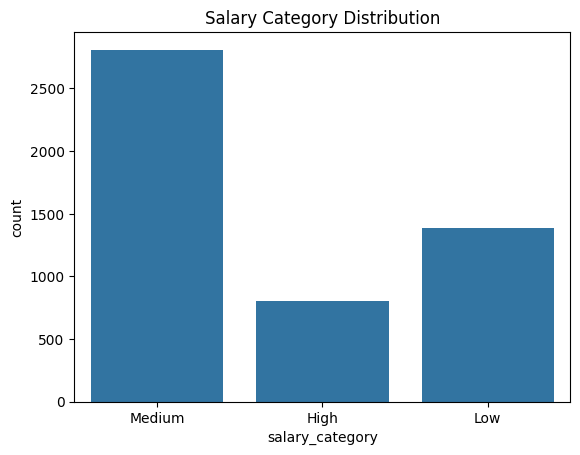

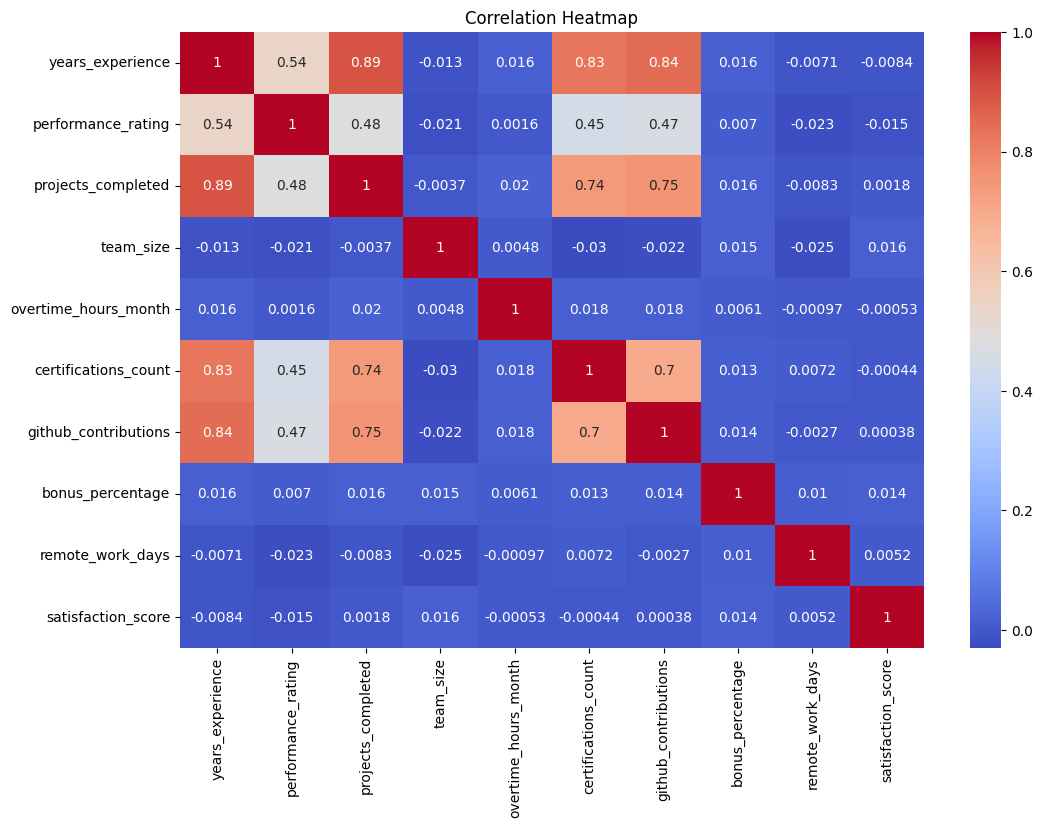

In [ ]:
# Check missing values
print(df.isnull().sum())

# Target distribution
sns.countplot(x="salary_category", data=df)
plt.title("Salary Category Distribution")
plt.show()

# Correlation (numeric only)
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


4. Data Preprocessing

In [ ]:
# Drop ID column (not useful)
df = df.drop("employee_id", axis=1)

# Handle missing values
df["bonus_percentage"] = df["bonus_percentage"].fillna(df["bonus_percentage"].median())
df["remote_work_days"] = df["remote_work_days"].fillna(df["remote_work_days"].median())
df["satisfaction_score"] = df["satisfaction_score"].fillna(df["satisfaction_score"].median())
df["stock_options"] = df["stock_options"].fillna("None")  # categorical

# Encode categorical variables
categorical_cols = df.select_dtypes(include=["object"]).columns.drop("salary_category")

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Encode target variable
le_target = LabelEncoder()
df["salary_category"] = le_target.fit_transform(df["salary_category"])

# Scale numeric features
X = df.drop("salary_category", axis=1)
y = df["salary_category"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Identify categorical features for CatBoost/LightGBM
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in categorical_features]
cat_cols = categorical_features  # alias for MLP embeddings part




5. Model Training & Validation

In [ ]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "MLP Neural Net": MLPClassifier(max_iter=500, random_state=42)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))



Random Forest Results:
Accuracy: 0.722
              precision    recall  f1-score   support

        High       0.77      0.45      0.57       161
         Low       0.72      0.64      0.68       277
      Medium       0.71      0.84      0.77       562

    accuracy                           0.72      1000
   macro avg       0.74      0.64      0.67      1000
weighted avg       0.73      0.72      0.71      1000



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:04:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
Accuracy: 0.792
              precision    recall  f1-score   support

        High       0.80      0.60      0.69       161
         Low       0.81      0.75      0.78       277
      Medium       0.78      0.87      0.82       562

    accuracy                           0.79      1000
   macro avg       0.80      0.74      0.76      1000
weighted avg       0.79      0.79      0.79      1000


MLP Neural Net Results:
Accuracy: 0.66
              precision    recall  f1-score   support

        High       0.59      0.47      0.52       161
         Low       0.64      0.62      0.63       277
      Medium       0.69      0.74      0.71       562

    accuracy                           0.66      1000
   macro avg       0.64      0.61      0.62      1000
weighted avg       0.66      0.66      0.66      1000



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=8,
    cat_features=categorical_features,
    eval_metric="Accuracy",
    random_seed=42,
    verbose=100
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,              # keeps the best iteration
    early_stopping_rounds=50          # stop if no improvement after 50 rounds
)


y_pred_cat = cat_model.predict(X_test)
print("\nCatBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat, target_names=le_target.classes_))


0:	learn: 0.6772500	test: 0.6530000	best: 0.6530000 (0)	total: 111ms	remaining: 55.5s
100:	learn: 0.8775000	test: 0.7490000	best: 0.7540000 (85)	total: 4.57s	remaining: 18.1s
200:	learn: 0.9610000	test: 0.7730000	best: 0.7760000 (191)	total: 5.57s	remaining: 8.28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.777
bestIteration = 216

Shrink model to first 217 iterations.

CatBoost Results:
Accuracy: 0.777
              precision    recall  f1-score   support

        High       0.84      0.56      0.67       161
         Low       0.78      0.71      0.74       277
      Medium       0.76      0.87      0.81       562

    accuracy                           0.78      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.78      0.78      0.77      1000



In [ ]:
lgb_model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="multiclass",
    num_class=len(np.unique(y)),
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)] # log every 50 rounds
)


y_pred_lgb = lgb_model.predict(X_test)
print("\nLightGBM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb, target_names=le_target.classes_))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 18
[LightGBM] [Info] Start training from score -1.829461
[LightGBM] [Info] Start training from score -1.281934
[LightGBM] [Info] Start training from score -0.576253
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.57031
[100]	valid_0's multi_logloss: 0.513774
[150]	valid_0's multi_logloss: 0.500593
[200]	valid_0's multi_logloss: 0.498285
[250]	valid_0's multi_logloss: 0.501465
Early stopping, best iteration is:
[210]	valid_0's multi_logloss: 0.497476

LightGBM Results:
Accuracy: 0.788
              precision    recall  f1-score   support

        High       0.82      0.58      0.68       161
         

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5475 - loss: 1.1540 - val_accuracy: 0.5630 - val_loss: 1.1812 - learning_rate: 0.0010
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6284 - loss: 0.9661 - val_accuracy: 0.5360 - val_loss: 1.0286 - learning_rate: 0.0010
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6327 - loss: 0.8982 - val_accuracy: 0.6800 - val_loss: 0.8637 - learning_rate: 0.0010
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6635 - loss: 0.8490 - val_accuracy: 0.6810 - val_loss: 0.8487 - learning_rate: 0.0010
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6713 - loss: 0.8318 - val_accuracy: 0.5970 - val_loss: 0.8973 - learning_rate: 0.0010
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6798 - loss: 0.8135 - val_accuracy: 0.5660 - val_loss: 0.9416 - learning_rate: 0.0010
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6724 - loss: 0.8141 - val_ac

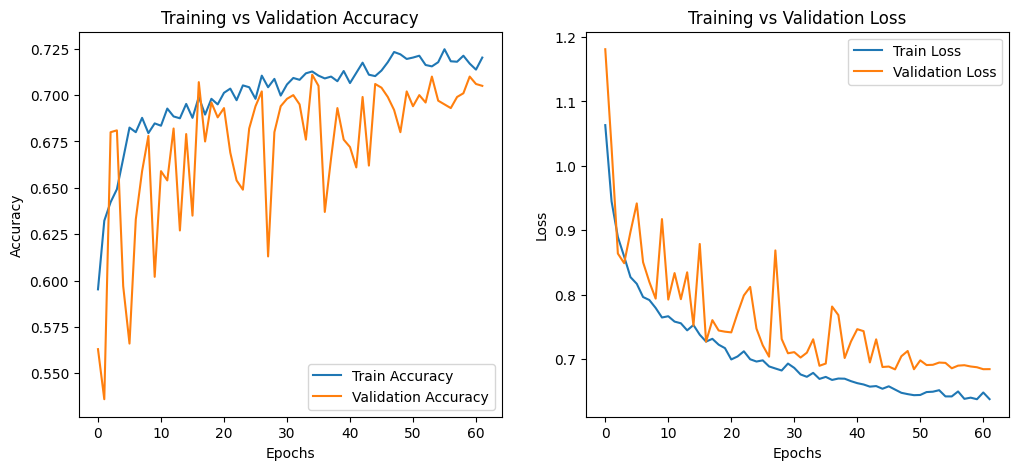

In [ ]:
# --- Preprocessing for embeddings (DataFrame-based split) ---
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split into categorical + numeric
X_num_train = X_train_df[num_cols].astype("float32")
X_num_test  = X_test_df[num_cols].astype("float32")

X_cat_train = X_train_df[cat_cols].astype("category")
X_cat_test  = X_test_df[cat_cols].astype("category")

# Function to prepare model inputs
def prepare_inputs(cat_df, num_df):
    return [cat_df[col].cat.codes.values for col in cat_cols] + [num_df.values]

train_inputs = prepare_inputs(X_cat_train, X_num_train)
test_inputs  = prepare_inputs(X_cat_test, X_num_test)

# --- Build improved embedding model ---
cat_inputs = []
embeddings = []

for col in cat_cols:
    input_dim = X[col].nunique() + 1   # number of categories + 1
    embed_dim = min(50, (input_dim // 2) + 1)
    inp = keras.Input(shape=(1,), name=f"{col}_input")
    emb = layers.Embedding(input_dim=input_dim, output_dim=embed_dim, name=f"{col}_emb")(inp)
    emb = layers.Flatten()(emb)
    cat_inputs.append(inp)
    embeddings.append(emb)

# Numeric input
num_inp = keras.Input(shape=(len(num_cols),), name="num_input")

# Concatenate embeddings + numeric
x = layers.Concatenate()(embeddings + [num_inp])

# Deep feedforward network with regularization
x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation="relu")(x)

# Output layer
output = layers.Dense(len(np.unique(y)), activation="softmax")(x)

# Build model
model = keras.Model(inputs=cat_inputs + [num_inp], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# --- Callbacks for better training ---
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7)

# --- Train model ---
history = model.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# --- Evaluate final model ---
nn_loss, nn_acc = model.evaluate(test_inputs, y_test, verbose=0)
print("\nNeural Network (Embeddings) Accuracy:", nn_acc)

# --- Plot training history ---
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


In [ ]:
results = {
    "CatBoost": accuracy_score(y_test, y_pred_cat),
    "LightGBM": accuracy_score(y_test, y_pred_lgb),
    "NN Embeddings": nn_acc
}

results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Accuracy"])
print("\nModel Comparison:\n", results_df)


Model Comparison:
                Accuracy
CatBoost          0.777
LightGBM          0.788
NN Embeddings     0.699


6. Model Tuning & Testing

In [ ]:
# a) Random Forest

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF Params:", grid_rf.best_params_)
print("Best RF Score:", grid_rf.best_score_)


Best RF Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RF Score: 0.7367527788993726


In [ ]:
# b) XGBoost

param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_xgb = RandomizedSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    param_grid_xgb, cv=3, scoring="accuracy", n_jobs=-1, n_iter=10, random_state=42
)
grid_xgb.fit(X_train, y_train)

print("Best XGB Params:", grid_xgb.best_params_)
print("Best XGB Score:", grid_xgb.best_score_)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:07:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best XGB Score: 0.8192494150524139


In [ ]:
# c) Neural Network (MLP)

param_grid_mlp = {
    "hidden_layer_sizes": [(64,), (128,64), (128,64,32)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001, 0.01],  # L2 regularization
    "learning_rate_init": [0.001, 0.01]
}

grid_mlp = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), param_grid_mlp, cv=3, scoring="accuracy", n_jobs=-1)
grid_mlp.fit(X_train, y_train)

print("Best MLP Params:", grid_mlp.best_params_)
print("Best MLP Score:", grid_mlp.best_score_)


Best MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001}
Best MLP Score: 0.6737475223378558


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# ============================
# 1. CatBoost Fine-Tuning
# ============================
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.1,
    depth=8,
    cat_features=categorical_features,
    eval_metric="Accuracy",
    random_seed=42,
    verbose=0
)

# Grid for tuning
cat_params = {
    "depth": [6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations": [500, 1000],
    "l2_leaf_reg": [1, 3, 5]
}

cat_grid = cat_model.grid_search(
    cat_params,
    X=X_train, y=y_train,
    cv=3,
    verbose=1
)

best_cat = CatBoostClassifier(
    **cat_grid["params"],
    cat_features=categorical_features,
    random_seed=42,
    verbose=0
)
best_cat.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred_cat = best_cat.predict(X_test)

print("\n=== CatBoost Final Test ===")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat, target_names=le_target.classes_))



bestTest = 0.745
bestIteration = 486

0:	loss: 0.7450000	best: 0.7450000 (0)	total: 2.84s	remaining: 2m 30s

bestTest = 0.8
bestIteration = 475

1:	loss: 0.8000000	best: 0.8000000 (1)	total: 5.36s	remaining: 2m 19s

bestTest = 0.80375
bestIteration = 223

2:	loss: 0.8037500	best: 0.8037500 (2)	total: 7.33s	remaining: 2m 4s

bestTest = 0.74125
bestIteration = 497

3:	loss: 0.7412500	best: 0.8037500 (2)	total: 9.32s	remaining: 1m 56s

bestTest = 0.81
bestIteration = 466

4:	loss: 0.8100000	best: 0.8100000 (4)	total: 11.3s	remaining: 1m 50s

bestTest = 0.80375
bestIteration = 342

5:	loss: 0.8037500	best: 0.8100000 (4)	total: 13.2s	remaining: 1m 45s

bestTest = 0.7375
bestIteration = 445

6:	loss: 0.7375000	best: 0.8100000 (4)	total: 16.2s	remaining: 1m 48s

bestTest = 0.80625
bestIteration = 468

7:	loss: 0.8062500	best: 0.8100000 (4)	total: 18.5s	remaining: 1m 46s

bestTest = 0.8025
bestIteration = 387

8:	loss: 0.8025000	best: 0.8100000 (4)	total: 22.2s	remaining: 1m 51s

bestTest = 0

In [ ]:
# ============================
# 2. LightGBM Fine-Tuning
# ============================
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

lgb_model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="multiclass",
    num_class=len(np.unique(y)),
    random_state=42
)

# Hyperparameter space
lgb_params = {
    "num_leaves": [31, 63, 127],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "max_depth": [-1, 10, 20],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

lgb_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=lgb_params,
    n_iter=10,
    scoring="accuracy",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

lgb_search.fit(X_train, y_train)

best_lgb = lgb_search.best_estimator_

y_pred_lgb = best_lgb.predict(X_test)

print("\n=== LightGBM Final Test ===")
print("Best Params:", lgb_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb, target_names=le_target.classes_))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 18
[LightGBM] [Info] Start training from score -1.829461
[LightGBM] [Info] Start training from score -1.281934
[LightGBM] [Info] Start training from score -0.576253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

=== LightGBM Final Test ===
Best Params: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': 10, 'learning

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Final testing & comparision

# Best models
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_mlp = grid_mlp.best_estimator_

final_models = {
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "MLP Neural Net": best_mlp
}

# Evaluate on test set
results = {}
for name, model in final_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Final Test Results:")
    print("Accuracy:", acc)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))

# Compare accuracies
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Accuracy"])
print("\nModel Comparison:\n", results_df)



Random Forest Final Test Results:
Accuracy: 0.724
[[ 74   0  87]
 [  0 176 101]
 [ 21  67 474]]
              precision    recall  f1-score   support

        High       0.78      0.46      0.58       161
         Low       0.72      0.64      0.68       277
      Medium       0.72      0.84      0.77       562

    accuracy                           0.72      1000
   macro avg       0.74      0.65      0.68      1000
weighted avg       0.73      0.72      0.72      1000


XGBoost Final Test Results:
Accuracy: 0.796
[[ 95   0  66]
 [  0 208  69]
 [ 21  48 493]]
              precision    recall  f1-score   support

        High       0.82      0.59      0.69       161
         Low       0.81      0.75      0.78       277
      Medium       0.79      0.88      0.83       562

    accuracy                           0.80      1000
   macro avg       0.81      0.74      0.76      1000
weighted avg       0.80      0.80      0.79      1000


MLP Neural Net Final Test Results:
Accuracy: 0.65

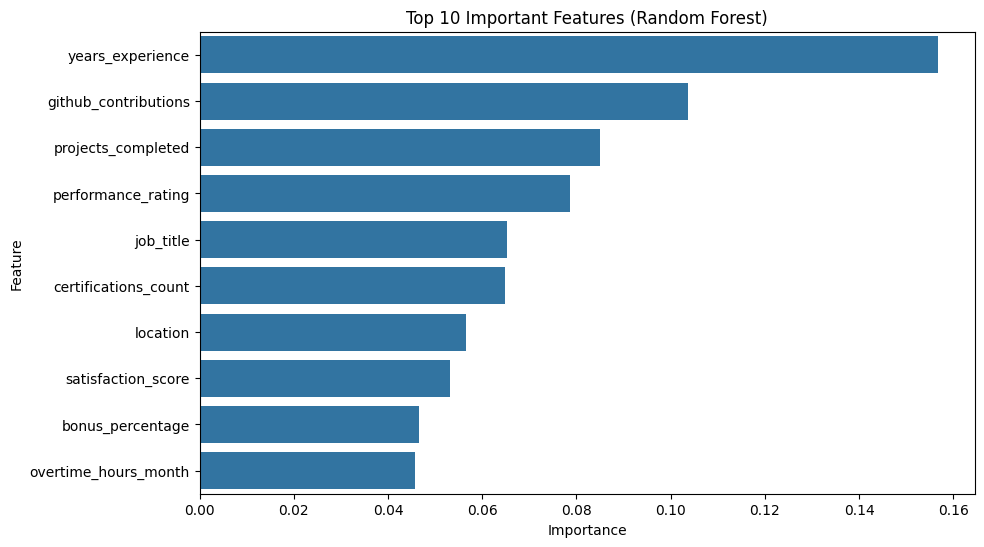

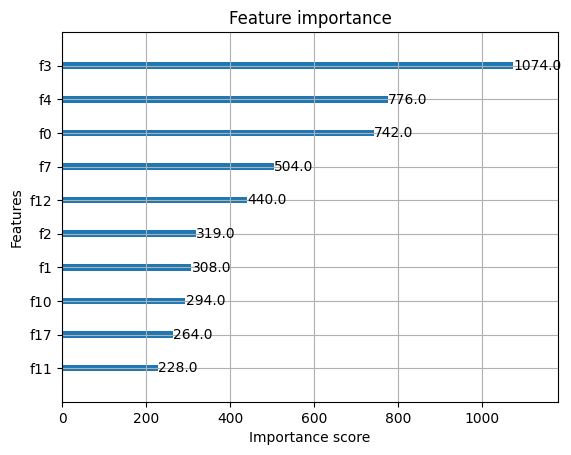

In [ ]:
# Feature Importance (Tree Models)

# Random Forest feature importance
importances = best_rf.feature_importances_
feat_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_df.head(10))
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

# XGBoost feature importance
xgb.plot_importance(best_xgb, max_num_features=10)
plt.show()


7. Conclusion

**Summary notes (to be written in report, not code):**

Which model performed best?

What features were most important?

Any limitations or biases?